# LDA

In [7]:
# imports
import sys
import os
import numpy as np
import pandas as pd
import sqlite3
import json
import datetime

from nltk import FreqDist
from nltk.util import ngrams
import re
import spacy
import math

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

## Model

Latent Dirichlet Allocation (LDA): LDA is a probabilistic approach to group texts in a document to specific topics. Topic models can organize a collection of unstructured documents to discover themes in them. LDA’s can be used to analyze text across blogs to discover the topics that run through them and how those topics are connected to each other.

The main assumption for the model is that documents are made up of a distribution of topics, and the topics are represented by a distribution of keywords. 


## Dataset

For this experiment lets pull in the news articles for the last few days

In [4]:
# Connect to database
database_url = "../datastore/app_data.db"
database = sqlite3.connect(database_url)

sql = "select * from articles"
source_data = pd.read_sql_query(sql, database)

print("Shape:",source_data.shape)
source_data.head()

Shape: (166, 7)


,id,source,article_link,article_date,article_title,article_content,article_dts
0,7c66bfc6f7b115ac9ea1c443d64d9f662a3c7257d06d2a...,npr,https://www.npr.org/2019/12/24/791102803/trump...,"December 24, 2019",Trump Downplays Threat Of 'Gift' From North Ko...,President Trump did not seem concerned Tuesday...,1.577146e+09
1,d5e50fa5f13830087bedc86232317ea1790d2417d4d729...,npr,https://www.npr.org/2019/12/23/790747698/newly...,"December 23, 2019",Ukraine Emails Fuel Democrats' Call For Impeac...,Party leaders in Congress continued to spar Mo...,1.577059e+09
2,2b767e199bd897158dd7f8b999bef7aa592b82fd4548eb...,nymag,http://nymag.com/intelligencer/2019/12/matt-sh...,"Dec. 24, 2019",GOP Lawmaker Plotted Insurrections to Establis...,Shea’s rebellion. Photo: Ted S Warren/AP/Shutt...,1.577146e+09
3,139c45cf3296a8e4f8bf50d3525b808be1620b3b670778...,nymag,http://nymag.com/intelligencer/2020/01/iran-ge...,"Jan. 2, 2020",U.S. Kills Iranian General Qasem Suleimani in ...,A Shiite Muslim pilgrim walks with a bag adorn...,1.577923e+09
4,f99ee44a2f210564c2eb3bc91a781f36dd6de44142047a...,nymag,http://nymag.com/intelligencer/2019/12/a-gloss...,"Dec. 31, 2019","A Glossary of Everyday Things, According to Trump",Donald Trump. Photo: Chip Somodevilla/Getty Im...,1.577750e+09


In [8]:
source_data['word_count'] = source_data['article_content'].str.split().str.len()

# View some metrics of data
print("Number of Article:",f'{source_data.shape[0]:,}')
print("Minimum Article Date:",datetime.datetime.fromtimestamp(min(source_data['article_dts'])).strftime("%b %d %Y"))
print("Maximum Article Date:",datetime.datetime.fromtimestamp(max(source_data['article_dts'])).strftime("%b %d %Y"))
print("Minimum Word Count:",min(source_data['word_count']))
print("Maximum Word Count:",f'{max(source_data["word_count"]):,}')

Number of Article: 166
Minimum Article Date: Dec 23 2019
Maximum Article Date: Jan 05 2020
Minimum Word Count: 111
Maximum Word Count: 5,195


In [9]:
# Preview some content
print("------ Article 1--------")
print(source_data["article_title"][0],source_data["article_content"][0][:500])
print("------ Article 2--------")
print(source_data["article_title"][1],source_data["article_content"][1][:500])
print("------ Article 3--------")
print(source_data["article_title"][2],source_data["article_content"][2][:500])

------ Article 1--------
Trump Downplays Threat Of 'Gift' From North Korea: Maybe It's A 'Beautiful Vase' President Trump did not seem concerned Tuesday when asked about the threat of a "Christmas present" from North Korea if the U.S. doesn't roll back economic sanctions on the country by the end of the year. "Maybe it's a nice present," Trump told reporters at an event at his Mar-a-Lago resort in Florida. "Maybe it's a present where he sends me a beautiful vase, as opposed to a missile test." Pyongyang imposed an end-of-year deadline for concessions from the U.S. earlier this month, but the Trump a
------ Article 2--------
Ukraine Emails Fuel Democrats' Call For Impeachment Trial Witnesses Party leaders in Congress continued to spar Monday over details of an impending impeachment trial in the Senate, with newly released emails giving more ammunition to Democrats in their requests for new witnesses. The emails, released late Friday to the Center for Public Integrity, are heavily redact

## Data Preprocessing

The data preprocessing steps that we will follow inorder to feed the data to the topic model are:
- Combine Title with Blog Content
- Remove line breaks
- Remove Special Characters
- Remove small words < 3 letters
- Convert text to lowercase
- Remove stop words
- Tokenize
- Lemmatization
- Remove custom stop words
- Remove blogs less than 15 words

In [10]:
# Custom stop words
custom_stopwords_file ='../datastore/custom_stopwords.txt'
custom_stopwords_df = pd.read_csv(custom_stopwords_file, header=None)
print("Shape:",custom_stopwords_df.shape)
custom_stopwords = custom_stopwords_df[0].tolist()

Shape: (6, 1)


In [11]:
# Utilities to perfrom data cleaning and preparation

nlp = spacy.load('en', disable=['parser', 'ner'])

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

# function to remove custom stopwords
def remove_custom_stopwords(texts):
    output = []
    for sent in texts:
        output.append([word for word in sent if word not in custom_stopwords])
    return output

In [12]:

# Merge title with content
source_data['text'] = source_data['article_title'] + " " + source_data["article_content"]

# Convert column to str
source_data['text'] = source_data['text'].apply(str)

# Replace line breaks
article_text = source_data['text'].str.replace("\n", " ")

# remove unwanted characters, numbers and symbols
article_text = article_text.str.replace("[^a-zA-Z#]", " ")

# remove short words (length < 3)
article_text = article_text.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# make entire text lowercase
article_text = [r.lower() for r in article_text]

# remove stopwords from the text
article_text = [remove_stopwords(r.split()) for r in article_text]

# Tokenize
tokenized_text = pd.Series(article_text).apply(lambda x: x.split())
# Lemmatize
tokenized_text = lemmatization(tokenized_text)
# Remove custom stopwords
tokenized_text = remove_custom_stopwords(tokenized_text)

flattened_text = []
for i in range(len(tokenized_text)):
    flattened_text.append(' '.join(tokenized_text[i]))

source_data['text'] = flattened_text

# Update word count
source_data['word_count'] = source_data['text'].str.split().str.len()

# Remove word count < 15
source_data = source_data[source_data['word_count'] > 14]
source_data = source_data.reset_index()

In [13]:
print("Shape:",source_data.shape)
source_data.head()

Shape: (166, 10)


,index,id,source,article_link,article_date,article_title,article_content,article_dts,word_count,text
0,0,7c66bfc6f7b115ac9ea1c443d64d9f662a3c7257d06d2a...,npr,https://www.npr.org/2019/12/24/791102803/trump...,"December 24, 2019",Trump Downplays Threat Of 'Gift' From North Ko...,President Trump did not seem concerned Tuesday...,1.577146e+09,64,beautiful vase president trump threat economic...
1,1,d5e50fa5f13830087bedc86232317ea1790d2417d4d729...,npr,https://www.npr.org/2019/12/23/790747698/newly...,"December 23, 2019",Ukraine Emails Fuel Democrats' Call For Impeac...,Party leaders in Congress continued to spar Mo...,1.577059e+09,149,fuel impeachment trial party leader spar detai...
2,2,2b767e199bd897158dd7f8b999bef7aa592b82fd4548eb...,nymag,http://nymag.com/intelligencer/2019/12/matt-sh...,"Dec. 24, 2019",GOP Lawmaker Plotted Insurrections to Establis...,Shea’s rebellion. Photo: Ted S Warren/AP/Shutt...,1.577146e+09,219,insurrection christian state rebellion photo l...
3,3,139c45cf3296a8e4f8bf50d3525b808be1620b3b670778...,nymag,http://nymag.com/intelligencer/2020/01/iran-ge...,"Jan. 2, 2020",U.S. Kills Iranian General Qasem Suleimani in ...,A Shiite Muslim pilgrim walks with a bag adorn...,1.577923e+09,250,iranian major qud force morning photo getty im...
4,4,f99ee44a2f210564c2eb3bc91a781f36dd6de44142047a...,nymag,http://nymag.com/intelligencer/2019/12/a-gloss...,"Dec. 31, 2019","A Glossary of Everyday Things, According to Trump",Donald Trump. Photo: Chip Somodevilla/Getty Im...,1.577750e+09,173,glossary everyday thing image mundane element ...


In [14]:
# Preview some pre processed text
print("------ Article 1--------")
print(source_data["text"][0][:500])
print("------ Article 2--------")
print(source_data["text"][2][:500])
print("------ Article 3--------")
print(source_data["text"][1][:500])

------ Article 1--------
beautiful vase president trump threat economic sanction country end year nice present trump reporter present beautiful vase missile test end year deadline concession early month administration sign plan pressure campaign entire nuclear arsenal sanction ambition top foreign policy priority series meeting solution surprise option unclear option rocket payload space underground nuclear test testing long range missile capable trump missile test surprise deal surprise trump
------ Article 2--------
insurrection christian state rebellion photo last year document american abortion sex marriage communism give opportunity renounce heresy manifesto author chairmanship writing church sermon old war current event historical context call spring text message shea anti fascist activist harassment violence shea online prescription treatment female antifa protester fist full hair face treat communist revolutionary background check list leader participation chat conversation lea

## Build Topic Model

Build the Latent Dirichlet Allocation (LDA) model for topic modeling.

In [16]:
tokenized_text = source_data['text'].apply(lambda x: x.split()).tolist()

NUM_TOPICS = 10
# Create term dictionary
id2word = corpora.Dictionary(tokenized_text)

# Convert into a Document Term Matrix corpus
corpus = [id2word.doc2bow(text) for text in tokenized_text]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=corpus,
                id2word=id2word,
                num_topics=NUM_TOPICS, 
                random_state=100,
                chunksize=1000,
                passes=200)

# View the generated topics
lda_model.print_topics()

[(0,
  '0.024*"trump" + 0.008*"eugenic" + 0.008*"time" + 0.007*"year" + 0.007*"people" + 0.006*"email" + 0.006*"conspiracy" + 0.006*"theory" + 0.006*"believer" + 0.006*"decade"'),
 (1,
  '0.016*"voter" + 0.016*"candidate" + 0.015*"state" + 0.015*"democratic" + 0.014*"sander" + 0.013*"people" + 0.011*"election" + 0.010*"year" + 0.008*"campaign" + 0.008*"primary"'),
 (2,
  '0.019*"family" + 0.015*"police" + 0.009*"hostage" + 0.008*"member" + 0.007*"suspect" + 0.006*"matsumura" + 0.006*"federal" + 0.006*"mother" + 0.006*"hour" + 0.006*"month"'),
 (3,
  '0.021*"war" + 0.016*"iranian" + 0.015*"trump" + 0.015*"attack" + 0.014*"military" + 0.013*"force" + 0.012*"american" + 0.011*"strike" + 0.010*"iraqi" + 0.010*"action"'),
 (4,
  '0.015*"election" + 0.013*"system" + 0.012*"computer" + 0.009*"voter" + 0.007*"year" + 0.007*"report" + 0.007*"dhs" + 0.007*"holder" + 0.007*"time" + 0.006*"security"'),
 (5,
  '0.025*"trump" + 0.011*"president" + 0.009*"year" + 0.009*"campaign" + 0.008*"time" + 0.0

In [18]:
# Build the list of Topic
topics_details = {}

for topic_num in range(lda_model.num_topics):
    word_prob = lda_model.show_topic(topic_num,topn=30)
    #topic_keywords = ", ".join([word for word, prob in word_prob])
    topic_keywords = [word for word, prob in word_prob]
    word_probability = [{"word":word,"probability":prob} for word, prob in word_prob]
    
    topics_details[topic_num] = {
        "topic_keywords" : topic_keywords,
        "word_probability" : word_probability
    }

# Assign the topics back to the source text
doc = 0
for doc_topics in lda_model[corpus]:
    doc_topics = sorted(doc_topics, key=lambda tup: (tup[1]), reverse=True)
    top = 1
    for topic_num,prob in doc_topics:
        #print(topic_num,prob)
        source_data.loc[doc, "topic_"+str(top)] = topic_num
        top = top +1
    
    doc = doc +1

In [20]:
print("Shape:",source_data.shape)
source_data[["article_date","article_title","article_content","topic_1","topic_2","topic_3"]].head()

Shape: (166, 14)


,article_date,article_title,article_content,topic_1,topic_2,topic_3
0,"December 24, 2019",Trump Downplays Threat Of 'Gift' From North Ko...,President Trump did not seem concerned Tuesday...,5.0,3.0,NaN
1,"December 23, 2019",Ukraine Emails Fuel Democrats' Call For Impeac...,Party leaders in Congress continued to spar Mo...,7.0,5.0,NaN
2,"Dec. 24, 2019",GOP Lawmaker Plotted Insurrections to Establis...,Shea’s rebellion. Photo: Ted S Warren/AP/Shutt...,5.0,3.0,NaN
3,"Jan. 2, 2020",U.S. Kills Iranian General Qasem Suleimani in ...,A Shiite Muslim pilgrim walks with a bag adorn...,3.0,NaN,NaN
4,"Dec. 31, 2019","A Glossary of Everyday Things, According to Trump",Donald Trump. Photo: Chip Somodevilla/Getty Im...,5.0,NaN,NaN


## Model Evaluation

We will visually look at a few of the articles to see how the model performed

In [21]:
def evaluate_topic_results(row):
    text = row["text"]
    for top in range(NUM_TOPICS):
        topic_column = "topic_"+str(top+1)
        if topic_column in row:
            topic_num = row[topic_column]
            #print(topic_num)
            if not math.isnan(topic_num):
                topic = topics_details[topic_num]
                #print(topic)
                topic_keywords = topic["topic_keywords"]

                #print(topic_1)

                for keyword in topic_keywords:
                    #print(keyword)
                    text = text.replace(' '+keyword+' ', ' \x1b[1;03;31;46m'+ keyword + '\x1b[0m ')
    
    print(text)

In [22]:
# View some results
evaluate_topic_results(source_data.loc[0])

beautiful vase president trump threat economic sanction country end year nice present trump reporter present beautiful vase missile test end year deadline concession early month administration sign plan pressure campaign entire nuclear arsenal sanction ambition top foreign policy priority series meeting solution surprise option unclear option rocket payload space underground nuclear test testing long range missile capable trump missile test surprise deal surprise trump


In [23]:
# View some results
evaluate_topic_results(source_data.loc[1])

fuel impeachment trial party leader spar detail impeachment trial email ammunition new witness email late center public integrity particular bolster argument president military aid political investigation message senior official office management less hour trump phone ukrainian president matter quiet duffey halt guidance light administration plan review assistance sensitive nature request information execute direction duffey email government official issue administration decision aid huge anxiety government aid unwise illegal center public integrity president government official money inquiry key people fact document copy press conference new witness trial trial witness document trial schumer sign groundwork question trial witness document american people testimony cover schumer plain simple trial article impeachment impeachment manager trial look sufficient vote president ability stall transfer leverage news morning trial new witness trial fact impartial juror early month chance offic

In [24]:
# View some results
evaluate_topic_results(source_data.loc[2])

insurrection christian state rebellion photo last year document american abortion sex marriage communism give opportunity renounce heresy manifesto author chairmanship writing church sermon old war current event historical context call spring text message shea anti fascist activist harassment violence shea online prescription treatment female antifa protester fist full hair face treat communist revolutionary background check list leader participation chat conversation leadership shea action expulsion government shea activity robertson plan prominent conservative trump alarm shea former supporter press state legislature document shea plan theocratic government unspecified collapse event former agent report last week leader total armed conflict political violence government state year period occupation wildlife phone call advance occupation report day occupation code name verumbellator detailed military style plan operation cold reality role member coalition western state day site state 

## Model Performance

In [25]:
# Model Perplexity
print("Perplexity:", lda_model.log_perplexity(corpus))

# Model Coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence", coherence_lda)

Perplexity: -7.537349439875256
Coherence 0.41461878280841596


## Evaluation of Topic Coherence

In this step we will create multiple models to test topic coherence

In [28]:
# Create term dictionary
id2word = corpora.Dictionary(tokenized_text)

# Convert into a Document Term Matrix corpus
corpus = [id2word.doc2bow(text) for text in tokenized_text]

# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

coherence_values = []
model_list = []
start = 5
limit = 100
step = 6
for num_topics in range(start, limit, step):
    model=LDA(corpus=corpus, id2word=id2word, num_topics=num_topics,
              random_state=100,chunksize=1000,passes=200)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokenized_text, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

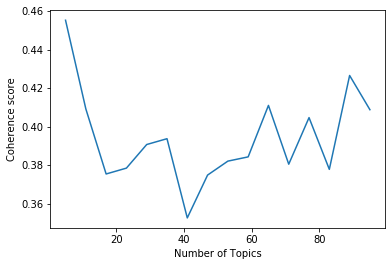

In [32]:
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

In [33]:
coherence_values

[0.45522642577900124,
 0.4092617841257411,
 0.3755168582455469,
 0.37855374773593126,
 0.3907903892601367,
 0.39380540782939033,
 0.3527327728562341,
 0.37494467297331896,
 0.38217891341999843,
 0.3843828156899292,
 0.4110681259077299,
 0.3805892483951833,
 0.40474445514726626,
 0.3779139723070282,
 0.4265849955285937,
 0.40884205493323106]